# Modeling
Shpaner, Leonid  
Robinson, Christopher  
Luis-Estrada, Jose  

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/Shared drives/Capstone - Best Group/navigating_crime/Code Library

/content/drive/Shared drives/Capstone - Best Group/navigating_crime/Code Library


In [3]:
####################################
## import the requisite libraries ##
####################################
import os
import csv
import pandas as pd
import numpy as np

# import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# import miscellaneous libraries
from prettytable import PrettyTable  # for creating tables

# import modeling libraries
import scipy as sp # for extracting pearson correlation coefficient
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, mean_squared_error,\
precision_score, recall_score, f1_score, accuracy_score,\
confusion_matrix, plot_confusion_matrix, classification_report

import warnings
# suppress warnings for cleaner output
warnings.filterwarnings('ignore')
# suppress future warnings for cleaner output
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [4]:
# set random state for reproducibility
rstate = 222

In [5]:
# check current working directory
current_directory = os.getcwd()
current_directory

'/content/drive/Shared drives/Capstone - Best Group/navigating_crime/Code Library'

### Assign Paths to Folders

In [101]:
# path to data folder
data_path1 = '/content/drive/Shareddrives/Capstone - Best Group/' \
           + 'navigating_crime/Data Folder/'

# path to the training file
data_path2 = '/content/drive/Shareddrives/Capstone - Best Group/' \
           + 'navigating_crime/Data Folder/train_set.csv'

# path to the validation file
data_path3 = '/content/drive/Shareddrives/Capstone - Best Group/' \
           + 'navigating_crime/Data Folder/valid_set.csv'    

# path to the feature engineered original dataframe (for eda purposes)
data_path4 = '/content/drive/Shareddrives/Capstone - Best Group/' \
           + 'Final_Data_20220719/df.csv'

# path to the validation file
data_path5 = '/content/drive/Shareddrives/Capstone - Best Group/' \
           + 'navigating_crime/Data Folder/test_set.csv'    

# path to the image library
image_path = '/content/drive/Shareddrives/Capstone - Best Group/' \
           + 'navigating_crime/Image Folder'        

In [102]:
# bring in original dataframe only for join purposes
train_set = pd.read_csv(data_path2).set_index('OBJECTID')
valid_set = pd.read_csv(data_path3).set_index('OBJECTID')
test_set = pd.read_csv(data_path5).set_index('OBJECTID')

In [103]:
# print the training 
print('The training set is', train_set.shape[0], 'rows and', train_set.shape[1],
      'columns.')
print('The validation set is', valid_set.shape[0], 'rows and', valid_set.shape[1],
      'columns.')
print('The testn set is', test_set.shape[0], 'rows and', test_set.shape[1],
      'columns.')

The training set is 21036 rows and 36 columns.
The validation set is 10518 rows and 36 columns.
The testn set is 10518 rows and 36 columns.


In [9]:
# subset the inputs for train and val (X_train, y_train, respectively) as 
# only input features, omitting the crime code truthing columns.
X_train = train_set.drop(columns=['Crime_Code'])
y_train = pd.DataFrame(train_set['Crime_Code'])

X_val = valid_set.drop(columns=['Crime_Code'])
y_val = pd.DataFrame(valid_set['Crime_Code'])

### Quadratic Discriminant Analysis (QDA)

A form of nonlinear discriminant analysis (Quadratic Discriminant Analysis) is used with an assumption that the data follows a Gaussian distribution such that a "class-specific covariance structure can be accommodated" (Kuhn & Johnson, 2016, p. 330). This method is used to improve performance over a standard Linear Discriminant Analysis (LDA) whereby the class boundaries are linearly separable. It does not require hyperparameters because it has a closed-form solution (Pedregosa et al., 2011). 

In [10]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

# Predict on val set
qda_pred = qda.predict(X_val)
# extract predicted probabilities for validation set
qda_proba = qda.predict_proba(X_val)[:,1]

## Logistic Regression

Logistic regression is deployed next for its ability to handle binary classification tasks with relative ease. The generalized linear model takes the following form:

$$y = \beta_0 + \beta_1x_1 +\beta_2x_2 +\cdots+\beta_px_p + \varepsilon$$

Describing the relationship between several important coefficients and features in the dataset can be modeled parametrically in the following form:


$$(\hat{\text{Crime Code}}) = \frac{\text{exp}(b_0+{b_1(\text{Victim Age}})+{b_2(\text{Month}})+b_3(\text{Victim Sex})+\cdot\cdot\cdot+b_px_p)}{1+\text{exp}(b_0+{b_1(\text{Victim Age}})+{b_2(\text{Month}})+b_3(\text{Victim Sex})+\cdot\cdot\cdot+b_px_p)}$$

The model is iterated through a list of cost penalties from 1 to one-hundred and trained with the following hyperparameters. Solvers used were *lbfgs* and *saga*. The *l1-ratio* and maximum iterations (*max_iter*) remained constant at a rate of 0.01, and 200, respectively.

In [11]:
def lr_hp(solver, penalty, l1_ratio, max_iter, rstate): 
    '''
    Inputs: 
        solver = hyperparameter
        penalty = 
        ratio = 
        cost = 
        maxiter = 
        rstate = random state for reproducibility
        x = width size of figure size
        y =  height size of figure size
    '''
    # manually tuning the logistic regression model
    C = list(range(1, 100, 10))
    LRtrainAcc = []
    LRvalAcc = []
    for cost in C:
        lr = LogisticRegression(solver=solver, penalty=penalty, l1_ratio=l1_ratio,
                                C=cost, max_iter=max_iter, random_state=rstate)
        lr.fit(X_train, y_train)

        # Predict on train set
        lr_pred_train = lr.predict(X_train)
        # Predict on val set
        tuned_lr = lr.predict(X_val)
        LRtrainAcc.append(accuracy_score(y_val, tuned_lr))
        LRvalAcc.append(accuracy_score(y_val, tuned_lr))
        print('Cost = %2.2f \t Validation Accuracy = %2.2f \t Training ' \
              'Accuracy = %2.2f'% (cost,accuracy_score(y_val, tuned_lr),
                               accuracy_score(y_train, lr_pred_train)))

    # plot cost by accuracy
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(C, LRtrainAcc, 'ro-', C, LRvalAcc,'bv--')
    ax.legend(['Training Accuracy','Validation Accuracy'])
    ax.set_title(f'Logistic Regression: Accuracy vs. Cost Over {penalty}' \
    + f' Penalty, {l1_ratio} = l1_ratio,  and {max_iter} Max Iterations')
    # plt.title('Logistic Regression: Accuracy vs. Cost')
    ax.set_xlabel('Cost'); ax.set_xscale('log')
    ax.set_ylabel('Accuracy')
    
    # accuracy and classification report (tuned model)
    print()
    print('Tuned Logistic Regression Model')
    print('Accuracy Score')
    print(accuracy_score(y_val, tuned_lr))
    print('Classification Report \n', classification_report(y_val, tuned_lr))

Cost = 1.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 11.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 21.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 31.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 41.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 51.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 61.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 71.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 81.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 91.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61

Tuned Logistic Regression Model
Accuracy Score
0.6217912150598973
Classification Report 
               precision    recall  f1-score   support

           0       0.62      0.47      0.54      4861
           1       0.62      0.75      0.68      5657

    accuracy                           0.62     10518
  

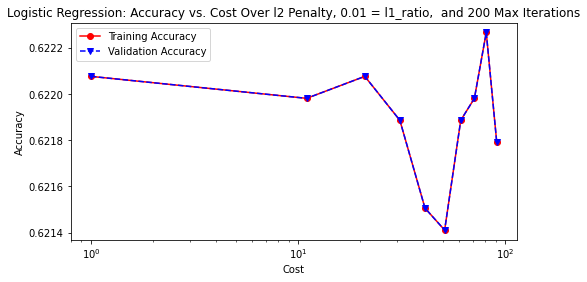

In [12]:
lr_hp(solver='lbfgs', penalty='l2', l1_ratio=0.01, max_iter=200, rstate=rstate)
# save the accuracy plot onto image path
plt.savefig(image_path + '/log_reg1_accuracy.png', bbox_inches = 'tight')

Cost = 1.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 11.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 21.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 31.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 41.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 51.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 61.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 71.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 81.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 91.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61

Tuned Logistic Regression Model
Accuracy Score
0.6219813652785701
Classification Report 
               precision    recall  f1-score   support

           0       0.62      0.47      0.54      4861
           1       0.62      0.75      0.68      5657

    accuracy                           0.62     10518
  

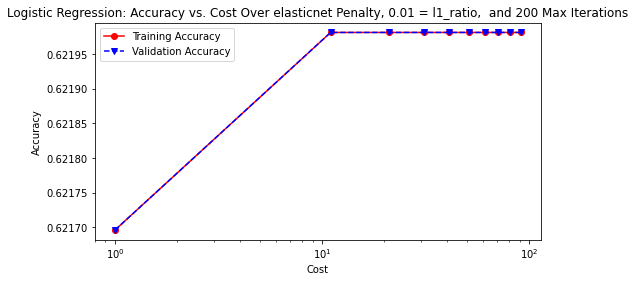

In [13]:
lr_hp(solver='saga', penalty='elasticnet', l1_ratio=0.01, max_iter=200, 
      rstate=rstate)
# save the accuracy plot onto image path
plt.savefig(image_path + '/log_reg2_accuracy.png', bbox_inches = 'tight')

In [14]:
def log_reg(solver, penalty, l1_ratio, max_iter, rstate):
    lr = LogisticRegression(solver=solver, penalty=penalty, l1_ratio=l1_ratio,
                            max_iter=max_iter, random_state=rstate)
    lr.fit(X_train, y_train)
    return lr

In [15]:
lr = log_reg(solver='saga', penalty='elasticnet', l1_ratio=0.01, 
        max_iter=200, rstate=rstate)
# Predict on val set
lr_pred = lr.predict(X_val)
# extract predicted probabilities for validation set
lr_proba = lr.predict_proba(X_val)[:, 1]

### Decision Tree Classifier

The remainder of the modeling stage commences with the application of tree-based classifiers. Basic classification trees facilitate data partitioning "into smaller, more homogeneous groups" (Kuhn & Johnson, 2016, p. 370). Instantiating a Decision Tree Classifier at a maximum depth (*max_depth*) of 2 is a good baseline for illustrating the effects of a minimum sample split to arrive at a pure node, but a more realistic depth of fifteen provides a more realistic and interpretable framework from which to assess subsequent classifiers with. No other hyperparameters are tuned.

In [90]:
dec_tree = DecisionTreeClassifier(max_depth=2)
dec_tree.fit(X_train, y_train)
# Predict on val set
dec_tree_pred =  dec_tree.predict(X_val)
# extract predicted probabilities for validation set
dec_tree_proba = dec_tree.predict_proba(X_val)[:,1]

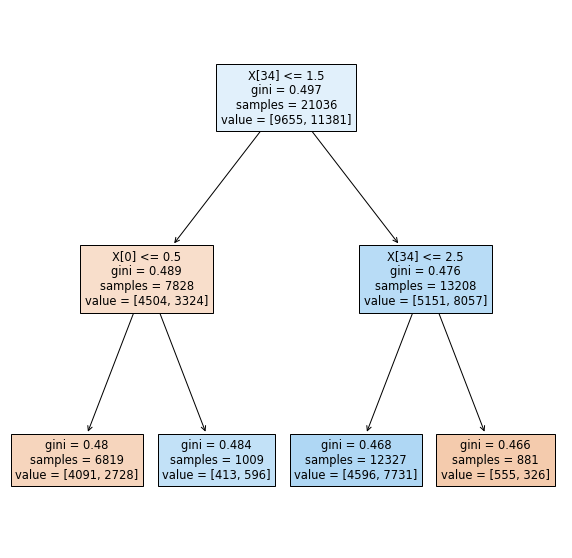

In [96]:
from sklearn import tree
fig, ax = plt.subplots(figsize = (10,10))

short_tree = tree.plot_tree(dec_tree, filled=True)
# save the accuracy plot onto image path
plt.savefig(image_path + '/decision_tree.png', bbox_inches = 'tight')

In [95]:
tree = DecisionTreeClassifier(max_depth=15)
tree.fit(X_train, y_train)
# Predict on val set
tree_pred =  tree.predict(X_val)
# extract predicted probabilities for validation set
tree_proba = tree.predict_proba(X_val)[:,1]

### Random Forest Classifier

Combining a baseline decision tree model with a bootstrapped aggregation (bagging) allowed for the first ensemble method of the Random Forest Classifier to be introduced. The model was iterated through a list of maximum depths ranging from fifteen to twenty and trained and with the *gini* and *entropy* hyperparameters.

In [60]:
def rf_hp(criterion, rstate):
    # Random Forest Tuning (Manual)
    rf_train_accuracy = []
    rf_val_accuracy = []
    max_depth = list(range(15, 21))
    for n in max_depth:
        rf = RandomForestClassifier(max_depth=n, criterion=criterion, 
                                    random_state=rstate)
        rf = rf.fit(X_train, y_train)
        rf_pred_train = rf.predict(X_train)
        rf_pred_val = rf.predict(X_val)
        rf_train_accuracy.append(accuracy_score(y_train, rf_pred_train))
        rf_val_accuracy.append(accuracy_score(y_val, rf_pred_val))
        print('Max Depth = %2.0f \t val Accuracy = %2.2f \t' \
              'Training Accuracy = %2.2f'% (n, accuracy_score(y_val, 
                                                              rf_pred_val),
                                            accuracy_score(y_train, 
                                                           rf_pred_train)))
    # max_depth = list(range(1, 15))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(max_depth, rf_train_accuracy, 'bv--', label='Training Accuracy')
    ax.plot(max_depth, rf_val_accuracy, 'ro--', label='Validaiton Accuracy')
    ax.legend(['Training Accuracy','Validation Accuracy'])
    ax.set_title(f'Random Forest Accuracy for {criterion.capitalize()}' + ' Criterion')
    ax.set_xlabel('Depth')
    ax.set_ylabel('Accuracy')
    
    # accuracy and classification report
    print()
    print('Tuned Random Forest Model')
    print('Accuracy Score', '\n')
    print(accuracy_score(y_val, rf_pred_val))
    print('Classification Report \n', 
          classification_report(y_val, rf_pred_val))

Max Depth = 15 	 val Accuracy = 0.77 	Training Accuracy = 0.83
Max Depth = 16 	 val Accuracy = 0.79 	Training Accuracy = 0.86
Max Depth = 17 	 val Accuracy = 0.81 	Training Accuracy = 0.88
Max Depth = 18 	 val Accuracy = 0.82 	Training Accuracy = 0.90
Max Depth = 19 	 val Accuracy = 0.84 	Training Accuracy = 0.92
Max Depth = 20 	 val Accuracy = 0.85 	Training Accuracy = 0.93

Tuned Random Forest Model
Accuracy Score 

0.8464536984217532
Classification Report 
               precision    recall  f1-score   support

           0       0.86      0.79      0.83      4861
           1       0.83      0.89      0.86      5657

    accuracy                           0.85     10518
   macro avg       0.85      0.84      0.84     10518
weighted avg       0.85      0.85      0.85     10518



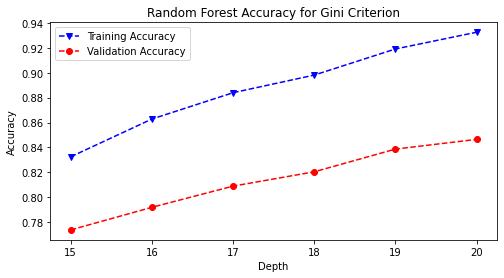

In [61]:
rf_hp('gini', rstate)
# save the accuracy plot onto image path
plt.savefig(image_path + '/rand_forest_gini_accuracy.png', 
            bbox_inches = 'tight')

Max Depth = 15 	 val Accuracy = 0.77 	Training Accuracy = 0.83
Max Depth = 16 	 val Accuracy = 0.79 	Training Accuracy = 0.85
Max Depth = 17 	 val Accuracy = 0.80 	Training Accuracy = 0.87
Max Depth = 18 	 val Accuracy = 0.82 	Training Accuracy = 0.90
Max Depth = 19 	 val Accuracy = 0.83 	Training Accuracy = 0.91
Max Depth = 20 	 val Accuracy = 0.85 	Training Accuracy = 0.93

Tuned Random Forest Model
Accuracy Score 

0.8495911770298535
Classification Report 
               precision    recall  f1-score   support

           0       0.87      0.80      0.83      4861
           1       0.84      0.89      0.86      5657

    accuracy                           0.85     10518
   macro avg       0.85      0.85      0.85     10518
weighted avg       0.85      0.85      0.85     10518



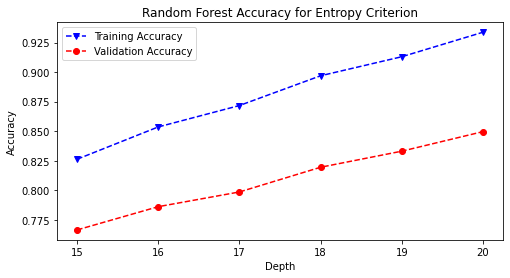

In [62]:
rf_hp('entropy', rstate)
# save the accuracy plot onto image path
plt.savefig(image_path + '/rand_forest_entropy_accuracy.png', 
            bbox_inches = 'tight')

In [63]:
def rand_for(n, criterion, rstate):
    rf = RandomForestClassifier(max_depth=n, criterion=criterion, 
                                random_state=rstate)

    rf.fit(X_train, y_train)
    return rf

In [64]:
rf = rand_for(20, criterion='entropy', rstate=rstate)
# Predict on val set
rf_pred = rf.predict(X_val)
# extract predicted probabilities for validation set
rf_proba = rf.predict_proba(X_val)[:, 1]

### XGBoost

XGBoost was the final model trained on the dataset for its scalability in a wide variety of end-to-end classification tasks. Parallelized computing allows for the algorithm to run "more than ten times faster than existing popular solutions on a single machine and scales to billions of examples in distributed or memory-limited settings" (Chen & Guestrin, 2016). Therefore, this gradient boosting ensemble method was chosen to supplement the preceding tree-based classifiers. 

The model can be summarized in the following equation:

$$\hat y_i = \large \sum_{k=1}^k f_k(x_i), f_k \epsilon \mathcal{F} $$

where output $\hat y_i$ is predicted via a summation of $k$ number of trees, where $f$ is the functional space of $\mathcal{F}$.

In [65]:
def xgb_hp(lr, rstate):
    # XGBoost tuning 
    xgb_train_accuracy = []
    xgb_val_accuracy = []
    max_depth = list(range(20, 31))
    for n in max_depth:
        xgb = XGBClassifier(max_depth=n, tree_method='hist', # speeds up time
                            learning_rate=lr, n_estimators=250, 
                            random_state=rstate, n_jobs=-1) # uses all cores
        xgb = xgb.fit(X_train, y_train)
        xgb_pred_train = xgb.predict(X_train)
        xgb_pred_val = xgb.predict(X_val)
        xgb_train_accuracy.append(accuracy_score(y_train, xgb_pred_train))
        xgb_val_accuracy.append(accuracy_score(y_val, xgb_pred_val))
        print('Max Depth = %2.0f \t Validation Accuracy = %2.2f \t' \
              'Training Accuracy = %2.2f' %(n, accuracy_score(y_val, 
                                            xgb_pred_val),
                                            accuracy_score(y_train, xgb_pred_train)))

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(max_depth, xgb_train_accuracy, 'bv--', label='Training Accuracy')
    ax.plot(max_depth, xgb_val_accuracy, 'ro--', label='Validation Accuracy')
    ax.set_title('XGBoost Accuracy')
    ax.set_xlabel('Depth')
    ax.set_ylabel('Accuracy')
    plt.legend()

    # accuracy and classification report
    print()
    print('Tuned XGBoost Model')
    print('Accuracy Score', '\n')
    print(accuracy_score(y_val, xgb_pred_val))
    print('Classification Report \n', classification_report(y_val, xgb_pred_val))

Max Depth = 20 	 Validation Accuracy = 0.88 	Training Accuracy = 0.98
Max Depth = 21 	 Validation Accuracy = 0.89 	Training Accuracy = 0.98
Max Depth = 22 	 Validation Accuracy = 0.89 	Training Accuracy = 0.98
Max Depth = 23 	 Validation Accuracy = 0.89 	Training Accuracy = 0.98
Max Depth = 24 	 Validation Accuracy = 0.89 	Training Accuracy = 0.98
Max Depth = 25 	 Validation Accuracy = 0.89 	Training Accuracy = 0.98
Max Depth = 26 	 Validation Accuracy = 0.89 	Training Accuracy = 0.98
Max Depth = 27 	 Validation Accuracy = 0.89 	Training Accuracy = 0.98
Max Depth = 28 	 Validation Accuracy = 0.88 	Training Accuracy = 0.98
Max Depth = 29 	 Validation Accuracy = 0.89 	Training Accuracy = 0.98
Max Depth = 30 	 Validation Accuracy = 0.89 	Training Accuracy = 0.98

Tuned XGBoost Model
Accuracy Score 

0.8855295683590036
Classification Report 
               precision    recall  f1-score   support

           0       0.88      0.87      0.88      4861
           1       0.89      0.90      0

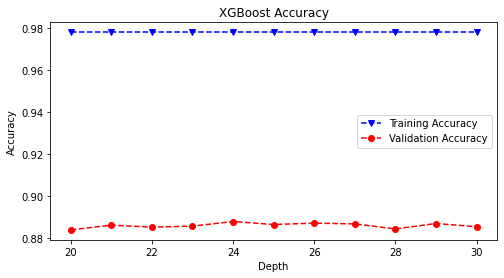

In [66]:
xgb_hp(lr=0.5, rstate=rstate)
# save the accuracy plot onto image path
plt.savefig(image_path + '/xgboost_accuracy.png', bbox_inches = 'tight')

In [67]:
def xgb(n, lr, rstate):
    xgb = XGBClassifier(max_depth=n, learning_rate=lr, 
                        random_state=rstate)
    xgb.fit(X_train, y_train)
    return xgb

In [68]:
xgb = xgb(n=31, lr=0.5, rstate=rstate)
# Predict on val set
xgb_pred = xgb.predict(X_val)
# extract predicted probabilities for validation set
xgb_proba = xgb.predict_proba(X_val)[:, 1]

## Model Evaluation

### Confusion Matrices

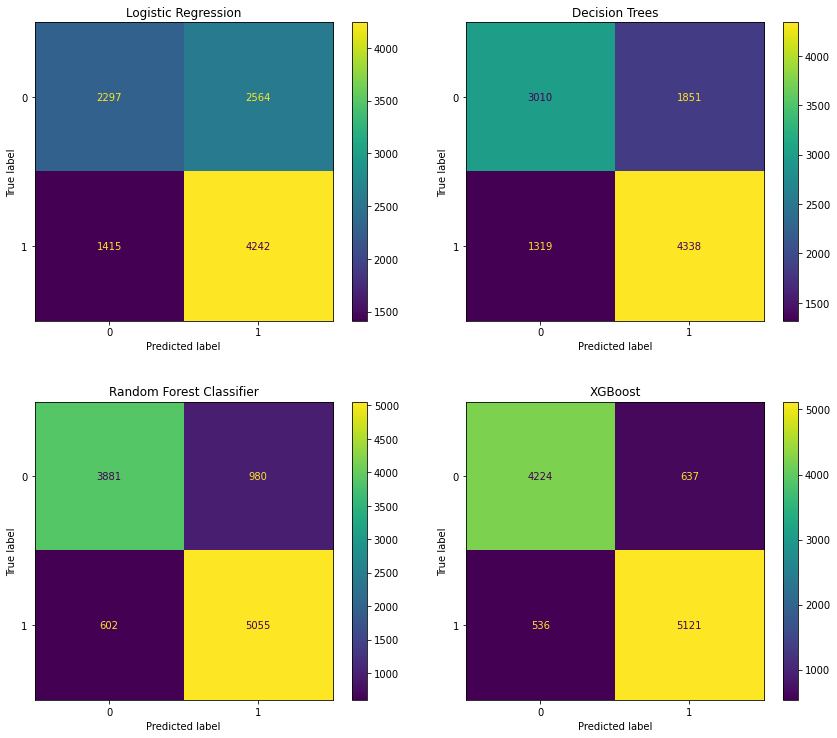

In [26]:
fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
fig.tight_layout(w_pad=2, h_pad= 6)

# Logistic Regression confusion matrix
plot_confusion_matrix(lr, X_val, y_val, ax=ax1)
ax1.set_title('Logistic Regression')

# Decision Tree confusion matrix
plot_confusion_matrix(tree, X_val, y_val, ax=ax2)
ax2.set_title('Decision Trees')

# Random Forest confusion matrix
plot_confusion_matrix(rf, X_val, y_val, ax=ax3)
ax3.set_title('Random Forest Classifier')

# Random Forest confusion matrix
plot_confusion_matrix(xgb, X_val, y_val, ax=ax4)
ax4.set_title('XGBoost')

# save the confusion matrices onto image path
plt.savefig(image_path + '/confusion_matrices.png', bbox_inches = 'tight')

plt.show()

### ROC Curves

In [27]:
def roc_plots(est_name, name, ax=None):
    roc = metrics.roc_curve(y_val, est_name)
    fpr,tpr,thresholds = metrics.roc_curve(y_val, est_name)
    auc = metrics.auc(fpr, tpr)

    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 10))
        plt.title('ROC Curves', fontsize=12)
        plt.xlabel('',fontsize=12) 
        plt.ylabel('',fontsize=12) 
    ax.plot(fpr, tpr, label=f'{name}: auc = {auc:.2}')
    ax.plot([0, 1], [0, 1], linestyle='--', color='#174ab0')
    return ax    

In [28]:
# create a dataframe for the models that were run
models = pd.DataFrame({'qda': qda_proba, 'log': lr_proba, 'rf': rf_proba, 
                       'tree': tree_proba, 'xgb': xgb_proba, 
                       'y_val': y_val['Crime_Code'].values})

# save out the models into a .csv file to be used with dash plotly
models.to_csv(data_path1 + 'models.csv', index=False)
models.head()

,qda,log,rf,tree,xgb,y_val
0,1.782625e-10,0.658370,0.369808,0.628533,0.020489,0
1,9.971863e-01,0.635430,0.802895,0.720096,0.991202,1
2,1.070735e-06,0.399391,0.327498,0.419451,0.179226,1
3,8.148866e-03,0.513235,0.609281,0.058824,0.928699,1
4,1.293167e-172,0.465000,0.370703,0.419451,0.521080,1


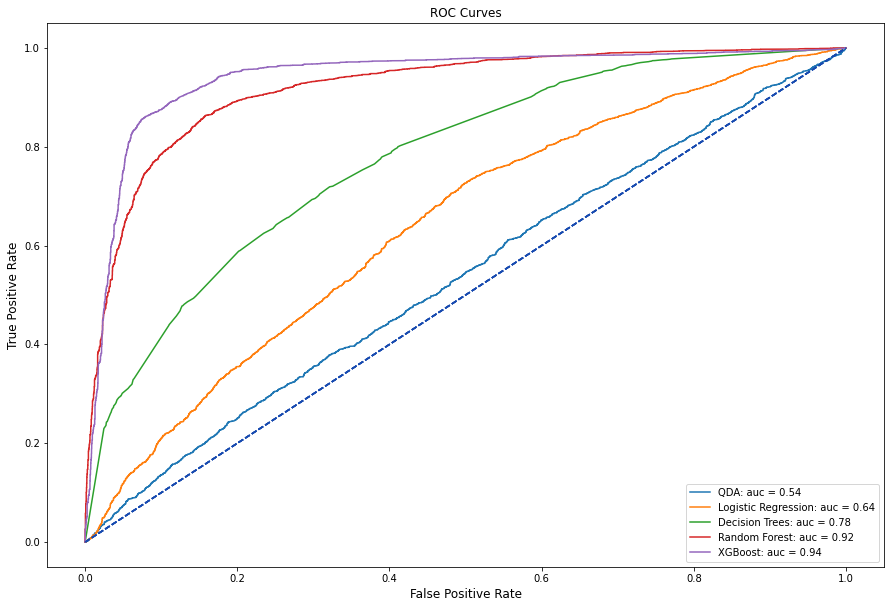

In [94]:
ax = roc_plots(est_name=qda_proba, name='QDA')
roc_plots(est_name=lr_proba, name='Logistic Regression', ax=ax)
roc_plots(est_name=tree_proba, name='Decision Trees', ax=ax)
roc_plots(est_name=rf_proba, name='Random Forest', ax=ax)
roc_plots(est_name=xgb_proba, name='XGBoost', ax=ax)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right');
# save the roc plot onto image path
plt.savefig(image_path + '/roc_curves.png', bbox_inches = 'tight')

### Performance Metrics

In [30]:
# function that generates auc values for any given value
def roc_auc(est_name):
    '''
    Input: 
        est_name: name of model(estimator/algorithn)
    Output:
        auc: auc score
    '''
    roc = metrics.roc_curve(y_val, est_name)
    fpr,tpr,thresholds = metrics.roc_curve(y_val, est_name)
    auc = metrics.auc(fpr, tpr)
    return auc

In [31]:
# retrieve the auc scores for all models into new variables
qda_auc = roc_auc(qda_pred)
lr_auc = roc_auc(lr_pred)
rf_auc = roc_auc(rf_pred)
xgb_auc = roc_auc(xgb_pred)

In [32]:
# QDA Performance Metrics
report1 = classification_report(y_val, qda_pred, output_dict=True)
accuracy1 = round(report1['accuracy'],4)
precision1 = round(report1['1']['precision'],4)
recall1 = round(report1['1']['recall'],4)
fl_score1 = round(report1['1']['f1-score'],4)

# Logistic Regression Performance Metrics
report2= classification_report(y_val, lr_pred, output_dict=True)
accuracy2 = round(report2['accuracy'],4)
precision2 = round(report2['1']['precision'],4)
recall2 = round(report2['1']['recall'],4)
fl_score2 = round(report2['1']['f1-score'],4)

# Decision Tree Performance Metrics                       
report3 = classification_report(y_val, tree_pred, output_dict=True)
accuracy3 = round(report3['accuracy'],4)
precision3 = round(report3['1']['precision'],4)
recall3 = round(report3['1']['recall'],4)
fl_score3 = round(report3['1']['f1-score'],4)

# Random Forest Performance Metrics
report4 = classification_report(y_val, rf_pred, output_dict=True)                
accuracy4 = round(report4['accuracy'],4)
precision4 = round(report4['1']['precision'],4)
recall4 = round(report4['1']['recall'],4)
fl_score4 = round(report4['1']['f1-score'],4)  

# XGBoost Performance Metrics
report5 = classification_report(y_val, xgb_pred, output_dict=True)                
accuracy5 = round(report5['accuracy'],4)
precision5 = round(report5['1']['precision'],4)
recall5 = round(report5['1']['recall'],4)
fl_score5 = round(report5['1']['f1-score'],4)  


table1 = PrettyTable()
table1.field_names = ['Model', 'Validation Accuracy', 
'Precision', 'Recall', 'F1-score']

table1.add_row(['QDA', accuracy1, 
precision1, recall1, fl_score1])
table1.add_row(['Decision Tree', accuracy2, precision2, recall2, fl_score2])
table1.add_row(['Logistic Regression', accuracy3, precision3, recall3, fl_score3])
table1.add_row(['Random Forest', accuracy4, precision4, recall4, fl_score4])
table1.add_row(['XGBoost', accuracy5, precision5, recall5, fl_score5])
print(table1)

+---------------------+---------------------+-----------+--------+----------+
|        Model        | Validation Accuracy | Precision | Recall | F1-score |
+---------------------+---------------------+-----------+--------+----------+
|         QDA         |        0.4953       |   0.6071  | 0.1748 |  0.2715  |
|    Decision Tree    |        0.6217       |   0.6233  | 0.7499 |  0.6807  |
| Logistic Regression |        0.6986       |   0.7009  | 0.7668 |  0.7324  |
|    Random Forest    |        0.8496       |   0.8376  | 0.8936 |  0.8647  |
|       XGBoost       |        0.8885       |   0.8894  | 0.9053 |  0.8972  |
+---------------------+---------------------+-----------+--------+----------+


In [33]:
# Mean-Squared Errors
mse1 = round(mean_squared_error(y_val, qda_pred),4)
mse2 = round(mean_squared_error(y_val, lr_pred),4)
mse3 = round(mean_squared_error(y_val, rf_pred),4)
mse4 = round(mean_squared_error(y_val, xgb_pred),4)

table2 = PrettyTable()
table2.field_names = ['Model', 'AUC', 'MSE']
table2.add_row(['QDA', round(qda_auc,4), mse1])
table2.add_row(['Logistic Regression', round(lr_auc,4), mse2])
table2.add_row(['Random Forest', round(rf_auc,4), mse3])
table2.add_row(['XGBoost', round(xgb_auc,4), mse4])
print(table2)

+---------------------+--------+--------+
|        Model        |  AUC   |  MSE   |
+---------------------+--------+--------+
|         QDA         | 0.5216 | 0.5047 |
| Logistic Regression | 0.6112 | 0.3783 |
|    Random Forest    | 0.846  | 0.1504 |
|       XGBoost       | 0.8871 | 0.1115 |
+---------------------+--------+--------+


### XGBoost Predictions

In [34]:
df_predictions_xgb = valid_set.copy()
df_preds_xgb = pd.concat([X_val, y_val], axis=1)
df_preds_xgb['Predictions'] = xgb_proba

In [35]:
df_preds_xgb.head()

,77th_Street,Central,Devonshire,Foothill,Harbor,Hollenbeck,Hollywood,Mission,N_Hollywood,Newton,...,Park_Playground,Parking_Lot,Sidewalk,Street,Vacant_Lot,Vict_Age,Month_No,Gender,Crime_Code,Predictions
OBJECTID,,,,,,,,,,,,,,,,,,,,,
62203,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,46,6,2,0,0.020489
233319,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,32,6,2,1,0.991202
95157,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,26,6,1,1,0.179226
83900,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,28,1,1,1,0.928699
61476,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,57,5,1,1,0.521080


In [36]:
df_preds_xgb.to_csv(data_path1 + 'df_preds_xgb.csv')

In [37]:
def plot_roc_preds(df, title, column):   
    ''' 
    This function creates roc curve plot for predictions
    Inputs:
        df_preds: dataframe with appended predictions
        title: title of the plot
        column: column to look at (i.e., 'Age', etc.)
        dictionary: key-value pair mapping for column
    '''
    
    # filter by each unique value in column    
    for value in df[column].unique():
        filtered_preds = df[df[column]==value]
        
        if filtered_preds.shape[0] > 0:
          # plot roc curve
          fpr, tpr, thresholds = metrics.roc_curve(filtered_preds['Crime_Code'], 
                                                   filtered_preds['Predictions'])
          y_preds = df[df[column]==value]['Predictions']
          y_true = df[df[column]==value]['Crime_Code']
          count = len(y_true)
          len_h0 = len(y_true[y_true==0])
          len_h1 = len(y_true[y_true==1])
              
          roc_auc = metrics.auc(fpr, tpr)
          plt.rcParams["figure.figsize"] = [16, 10]
          plt.title(title)
          plt.plot(fpr, tpr, label = f'AUC for {value} = {roc_auc:.3f},'
                                    f' count: {len(y_true)}, H0: {len_h0},'
                                    f' H1: {len_h1}')
          plt.plot([0, 1], [0, 1], 'r--')
          plt.xlim([0, 1])
          plt.ylim([0, 1])
          plt.xlabel('False Positive Rate')
          plt.ylabel('True Positive Rate')
          plt.legend(loc="lower right")   


In [38]:
df = pd.read_csv(data_path4).set_index('OBJECTID')

In [39]:
# join columns of interest from eda datframe to the prediction dataframe
# for further ROC Curve analysis
df_preds_roc= df_preds_xgb.join(df[['Type', 'age_bin', 'Victim_Sex', 
                                    'Victim_Desc', 'Time_of_Day', 'Month', 
                                    'AREA_NAME']], how='left')

In [40]:
# drop individual streets from new dataframe, since we are not interested in
# investing performance operating points at this granularity. However, 
# street tpes, age groups, time of day, and month are retained such that
# this analysis can be made
df_preds_roc = df_preds_roc.drop(columns=['77th_Street', 'Central', 'Devonshire', 
                                          'Foothill', 'Harbor', 'Hollenbeck', 
                                          'Hollywood', 'Mission', 'N_Hollywood',
                                          'Newton','Northeast', 'Olympic', 
                                          'Pacific', 'Rampart', 'Southeast', 
                                          'Southwest','Topanga', 'Van_Nuys', 
                                          'West_LA', 'West_Valley', 'Wilshire',
                                          # remove individual time of day cols
                                          # since these are already contained
                                          # within 'Time_of_Day' col
                                          'Afternoon', 'Evening', 'Morning', 
                                          'Night',
                                          # remove individual street type cols
                                          # since these are already contained
                                          # within 'Type' column
                                          'Alley', 'Driveway', 'Park_Playground', 
                                          'Parking_Lot', 'Sidewalk', 'Street', 
                                          'Vacant_Lot', 
                                          # remove 'Month_No' col since relvant
                                          # info is contained within 'Month' col
                                          'Month_No',
                                          # remove 'Vict_Age' since we have 
                                          # binned it as 'age_bin'
                                          'Vict_Age',
                                          # drop gender in lieu of 'Victim_Sex'
                                          'Gender'],
                                          errors='ignore')

In [41]:
df_preds_roc.head().T

OBJECTID,62203,233319,95157,83900,61476
Crime_Code,0,1,1,1,1
Predictions,0.020489,0.991202,0.179226,0.928699,0.52108
Type,Minor,Minor,Minor,Minor,Minor
age_bin,45-50,30-35,25-30,25-30,55-60
Victim_Sex,M,M,F,F,F
Victim_Desc,Other Asian,Hispanic/Latin/Mexican,Hispanic/Latin/Mexican,Hispanic/Latin/Mexican,White
Time_of_Day,Evening,Evening,Evening,Night,Evening
Month,June,June,June,January,May
AREA_NAME,Newton,Newton,Hollywood,Newton,Central


In [42]:
df_preds_roc.columns

Index(['Crime_Code', 'Predictions', 'Type', 'age_bin', 'Victim_Sex',
       'Victim_Desc', 'Time_of_Day', 'Month', 'AREA_NAME'],
      dtype='object')

In [43]:
options = {'age_bin': 'Age Bin',  'Type': 'Type', 'Victim_Sex': 'Victim Sex', 
           'Victim_Desc': 'Victim Descent', 'Time_of_Day': 'Time of Day', 
           'Month': 'Month', 'AREA_NAME': 'Area Name', 'Premises': 'Premises'}

df_preds_roc = df_preds_roc.rename(columns=options)

In [44]:
# write out the df_preds (+) joined columns of interest file to csv on path
df_preds_roc.to_csv(data_path1 + 'df_preds_roc.csv', index=False)

### ROC Curves by Month of Crime

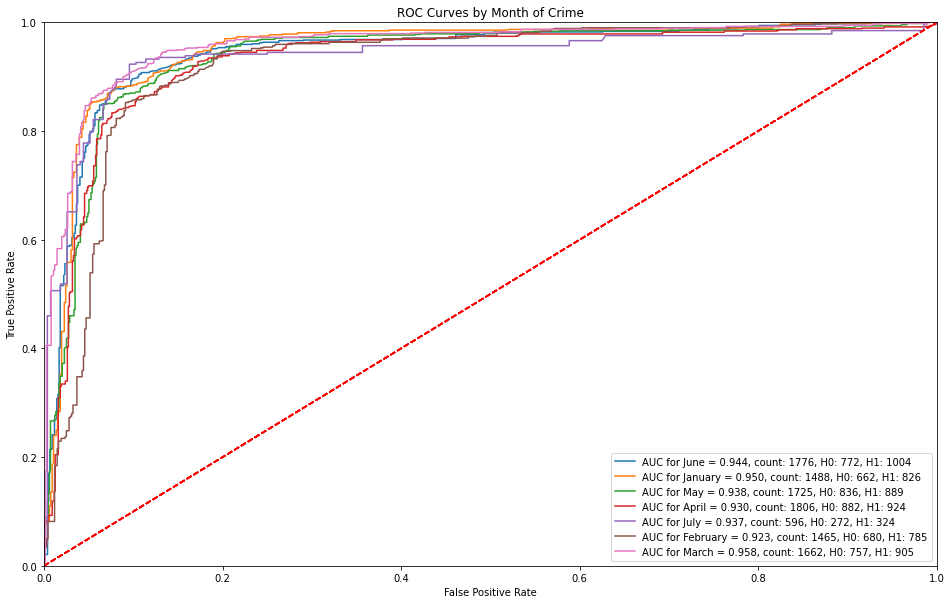

In [45]:
plot_roc_preds(df_preds_roc, 'ROC Curves by Month of Crime', 'Month')
# save the roc plot onto image path
plt.savefig(image_path + '/roc_by_month.png', bbox_inches = 'tight')

### ROC Curves by Time of Day

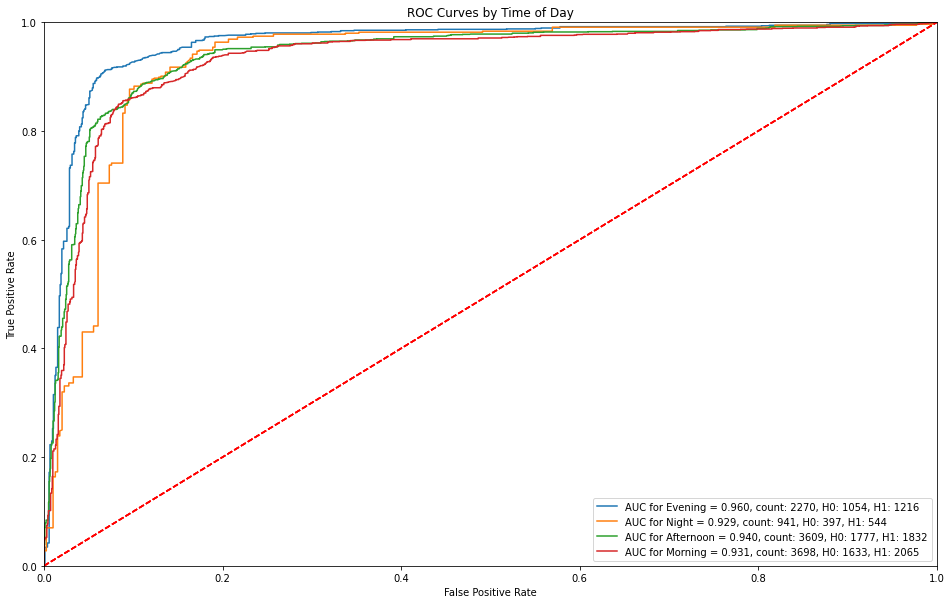

In [46]:
plot_roc_preds(df_preds_roc, 'ROC Curves by Time of Day', 'Time of Day')
# save the roc plot onto image path
plt.savefig(image_path + '/roc_by_time_of_day.png', bbox_inches = 'tight')

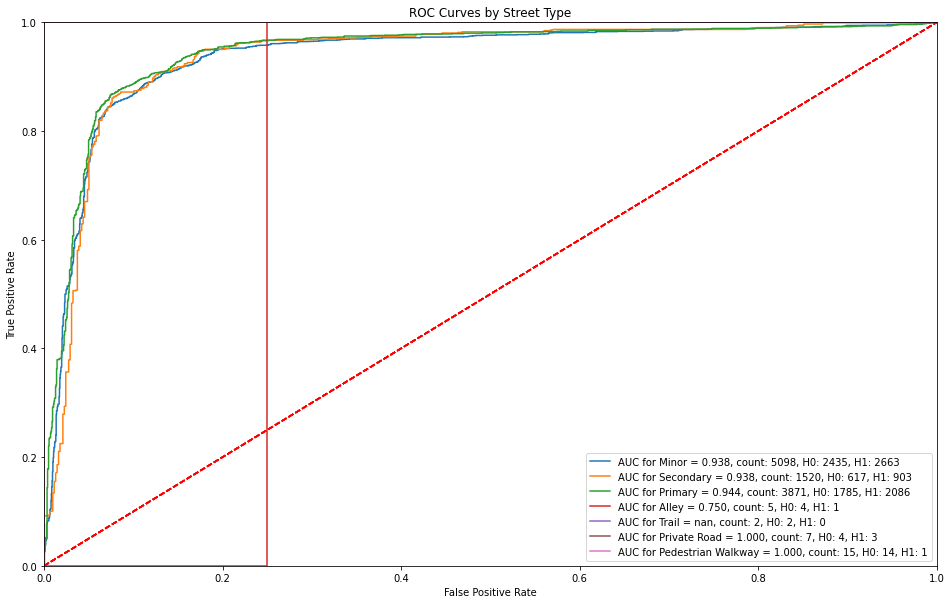

In [47]:
plot_roc_preds(df_preds_roc, 'ROC Curves by Street Type', 'Type')
# save the roc plot onto image path
plt.savefig(image_path + '/roc_by_street_type.png', bbox_inches = 'tight')

In [48]:
df_preds_roc.columns

Index(['Crime_Code', 'Predictions', 'Type', 'Age Bin', 'Victim Sex',
       'Victim Descent', 'Time of Day', 'Month', 'Area Name'],
      dtype='object')

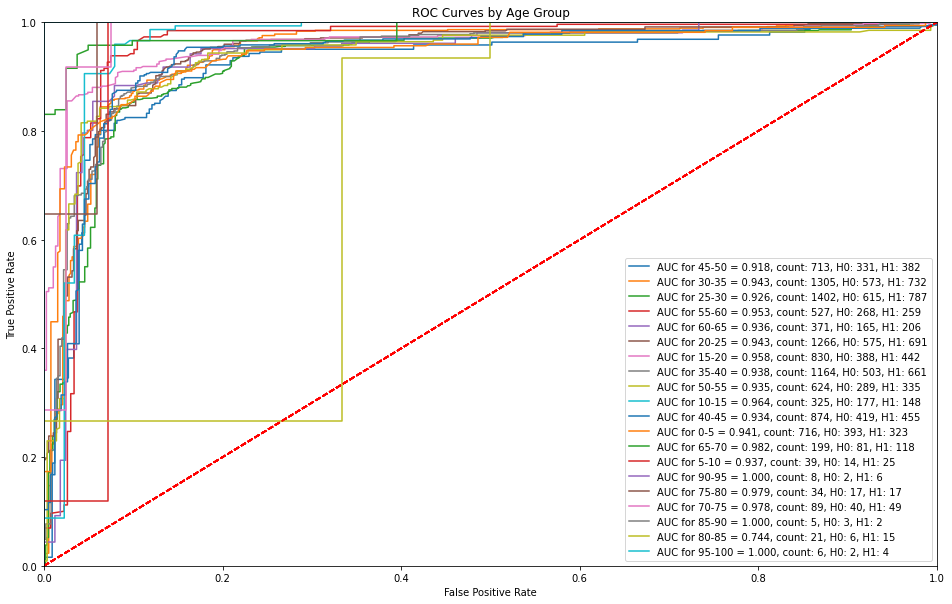

In [49]:
plot_roc_preds(df_preds_roc, 'ROC Curves by Age Group', 'Age Bin')
# save the roc plot onto image path
plt.savefig(image_path + '/roc_by_age.png', bbox_inches = 'tight')

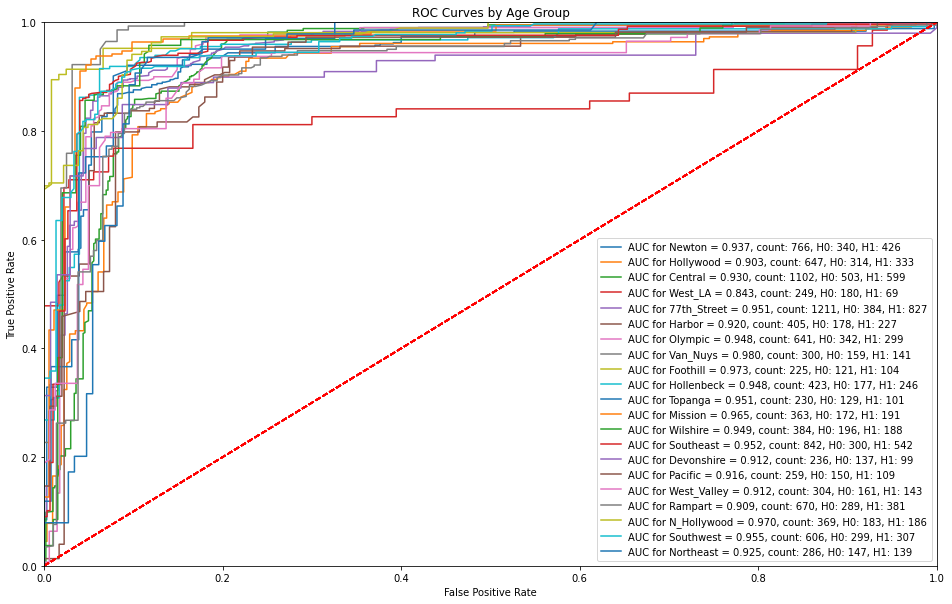

In [50]:
plot_roc_preds(df_preds_roc, 'ROC Curves by Age Group', 'Area Name')
# save the roc plot onto image path
plt.savefig(image_path + '/roc_by_area.png', bbox_inches = 'tight')

## Compare Predictions of Top Two Models

XGBoost was the top performing model in terms of AUC, accuracy, precision, recall, f1-score, and lowest mean-squared error. For comparison purposes, predictions are generated for the second best model (Random Forest).

In [51]:
df_predictions_rf = valid_set.copy()
df_preds_rf = pd.concat([X_val, y_val], axis=1)
df_preds_rf['Predictions'] = rf_proba

In [52]:
df_preds_rf.to_csv(data_path1 + 'df_preds_rf.csv')

In [53]:
df_preds_rf.head()

,77th_Street,Central,Devonshire,Foothill,Harbor,Hollenbeck,Hollywood,Mission,N_Hollywood,Newton,...,Park_Playground,Parking_Lot,Sidewalk,Street,Vacant_Lot,Vict_Age,Month_No,Gender,Crime_Code,Predictions
OBJECTID,,,,,,,,,,,,,,,,,,,,,
62203,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,46,6,2,0,0.369808
233319,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,32,6,2,1,0.802895
95157,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,26,6,1,1,0.327498
83900,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,28,1,1,1,0.609281
61476,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,57,5,1,1,0.370703


In [54]:
# create a new column of predictions for RF (for naming purposes)
df_preds_rf['Predictions_RF'] = df_preds_rf['Predictions']
# drop any other columns in the dataframe since only predictions are of interest
df_preds_rf_preds = df_preds_rf[['Predictions_RF', 'Crime_Code']]

# create a new column of predictions for XGB (for naming purposes)
df_preds_xgb['Predictions_XGB'] = df_preds_xgb['Predictions']
# drop any other columns in the dataframe since only predictions are of interest
df_preds_xgb_preds = df_preds_xgb[['Predictions_XGB']]

In [55]:
# join the prediction columns of XGB and RF dataframes, respectively
pred_comparison = df_preds_xgb_preds.join(df_preds_rf_preds, how='left')
pred_comparison.head()

,Predictions_XGB,Predictions_RF,Crime_Code
OBJECTID,,,
62203,0.020489,0.369808,0
233319,0.991202,0.802895,1
95157,0.179226,0.327498,1
83900,0.928699,0.609281,1
61476,0.521080,0.370703,1


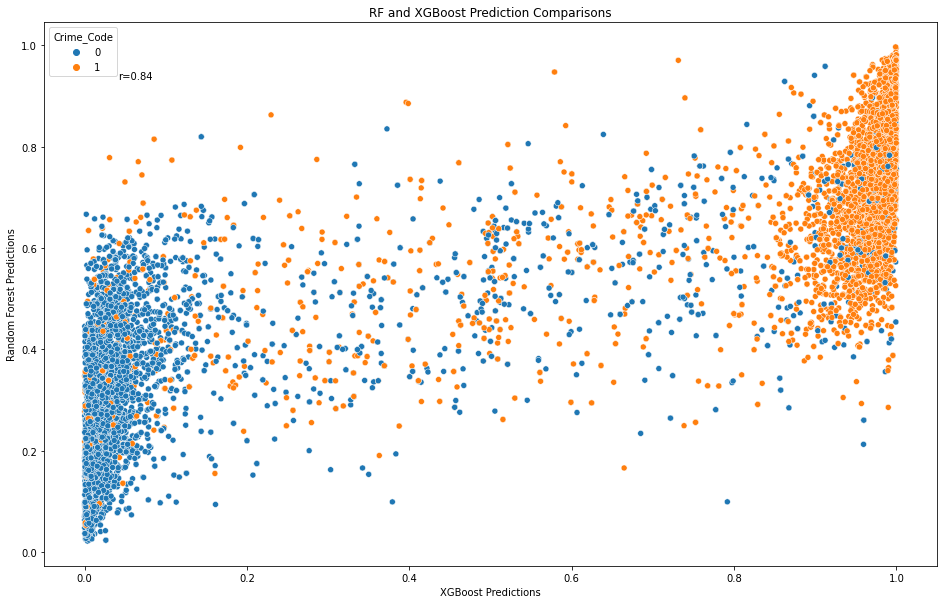

In [99]:
sns.scatterplot(data=pred_comparison, x=pred_comparison['Predictions_XGB'],
                y = pred_comparison['Predictions_RF'], hue='Crime_Code')

plt.title('RF and XGBoost Prediction Comparisons')
plt.xlabel('XGBoost Predictions')
plt.ylabel('Random Forest Predictions')

# call the scipy function for pearson correlation
r, p = sp.stats.pearsonr(x=pred_comparison['Predictions_XGB'],
                y = pred_comparison['Predictions_RF'])
# annotate the pearson correlation coefficient text to 2 decimal places
plt.text(.05, .8, 'r={:.2f}'.format(r),
            transform=ax.transAxes)

# save the prediction comparisons onto image path
plt.savefig(image_path + '/pred_comparisons_colored.png', bbox_inches = 'tight')
plt.show()

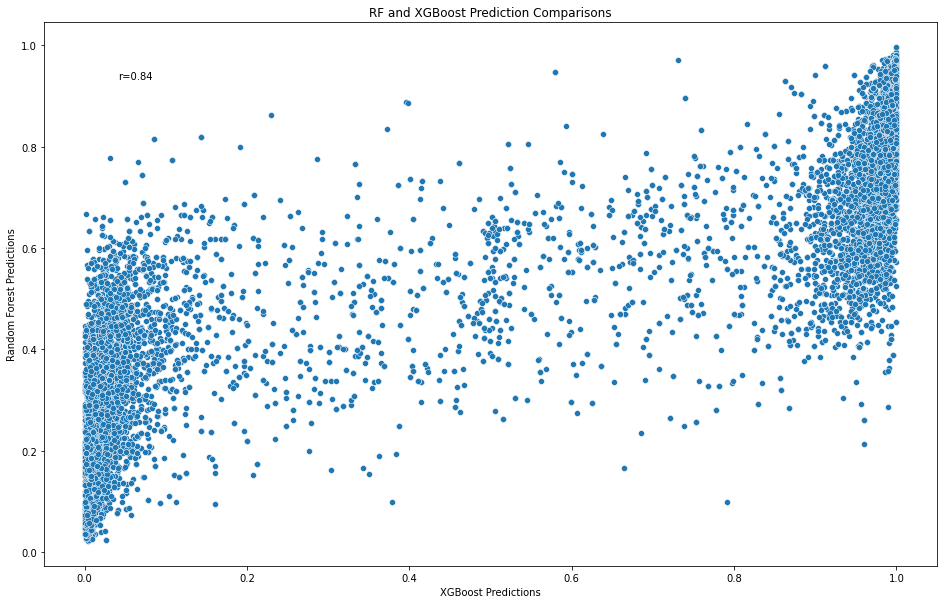

In [100]:
sns.scatterplot(data=pred_comparison, x=pred_comparison['Predictions_XGB'],
                y = pred_comparison['Predictions_RF'])

plt.title('RF and XGBoost Prediction Comparisons')
plt.xlabel('XGBoost Predictions')
plt.ylabel('Random Forest Predictions')

# call the scipy function for pearson correlation
r, p = sp.stats.pearsonr(x=pred_comparison['Predictions_XGB'],
                y = pred_comparison['Predictions_RF'])
# annotate the pearson correlation coefficient text to 2 decimal places
plt.text(.05, .8, 'r={:.2f}'.format(r),
            transform=ax.transAxes)

# save the prediction comparisons onto image path
plt.savefig(image_path + '/pred_comparisons.png', bbox_inches = 'tight')
plt.show()